In [73]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

In [74]:
# Define hyperparameters

device = "cuda:0" if torch.cuda.is_available() else "cpu"
EMBED_DIM = 32
BATCH_SIZE = 1000
DROPOUT = 0.2
LR=6e-3
WD=1e-5

In [75]:
# Import the adults dataset as pandas dataframes
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets

In [76]:
# Get features with categorical data 
categorical_columns = X.select_dtypes(include=['object']).columns
print(categorical_columns)
targets = y.select_dtypes(include=['object']).columns
label_mappings = {} # Dict to remember label -> category mapping
unique_per_cols = {} # Keep track of unique categories per feature

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [77]:
# Create numeric labels for categorical features
label_encoder = LabelEncoder()
for col in categorical_columns:
    X.loc[:, col] = label_encoder.fit_transform(X[col].astype(str))
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    unique_per_cols[col] = len(set(X[col])) # Add to 

# Create numeric labels for classification 
for col in targets:
    y.loc[:, col] = label_encoder.fit_transform(y[col].astype(str))
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [78]:
# Handle nan for discrete data by replacing with avg value of the feature
print(X.select_dtypes(include=['int', 'float']).columns)
for col in X.select_dtypes(include=['int', 'float']).columns:
    X.loc[:, col].fillna(X[col].mean(), inplace=True) 

# idk why but there is stupid SettingWithCopyWarning error here

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


C:\Users\Byron\AppData\Local\Temp\ipykernel_24112\1990399500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col].fillna(X[col].mean(), inplace=True)


In [79]:
# Define our own dataset class for easier processing
class AdultDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        Y = Y.copy().values.astype(np.int64)
        self.X1 = X.loc[:,emb_cols].copy().values.astype(np.int64) # categorical columns
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32) #numerical columns
        self.y = Y
      
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [80]:
# Load our dataset with AdultDataset class
train_tmp = AdultDataset(X[:-5000], y[:-5000], emb_cols=categorical_columns)
val_tmp = AdultDataset(X[-5000:], y[-5000:], emb_cols=categorical_columns)

train = DataLoader(train_tmp, batch_size=BATCH_SIZE,shuffle=True,drop_last=True,
                   collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val = DataLoader(val_tmp, batch_size=BATCH_SIZE,shuffle=True,drop_last=True,
                 collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [81]:
# Define our model 
class IncomePredictor(nn.Module):

    # Arg: embedding_sizes -> [CATEGORIES, EMBED_SIZE] for categorical features
    #      n_cont -> number of continuous features
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) 
        self.n_emb, self.n_cont = n_emb, n_cont

        # Linear layers 
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 100)
        self.lin2 = nn.Linear(100, 50)
        self.lin3 = nn.Linear(50, 5)

        # Normalization layers
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(50)

        # Dropout layers
        self.emb_drop = nn.Dropout(DROPOUT)
        self.drops = nn.Dropout(DROPOUT)
        
    # Arg: x_cat -> categorical features of X
    #      x_cont -> continuous features of X
    def forward(self, x_cat, x_cont):
        
        # Pass each categorical feature through its respective embedding layer and concatenate
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)

        # Normalize continuous data
        x2 = self.bn1(x_cont)

        # Concatenate categorical + continuous data 
        x = torch.cat([x, x2], 1)

        # Pass through activation function 
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [82]:
# Create model 
embedding_sizes = [(n_categories, EMBED_DIM) for _,n_categories in unique_per_cols.items()] 
# embedding_sizes = [(c, min(50, (c+1)//2)) for _,c in unique_per_cols.items()] #embedding sizes for the chosen columns
model = IncomePredictor(embedding_sizes, len(X.select_dtypes(include=['int', 'float']).columns))
model.to(device)
# Note: using fixed EMBED_DIM size for all categorical features for now, can vary later ex: greater dim for features with more categories

IncomePredictor(
  (embeddings): ModuleList(
    (0): Embedding(10, 32)
    (1): Embedding(16, 32)
    (2): Embedding(7, 32)
    (3): Embedding(16, 32)
    (4): Embedding(6, 32)
    (5): Embedding(5, 32)
    (6): Embedding(2, 32)
    (7): Embedding(43, 32)
  )
  (lin1): Linear(in_features=262, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=5, bias=True)
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.2, inplace=False)
  (drops): Dropout(p=0.2, inplace=False)
)

In [83]:
# Pytorch optimizer (using Adam)
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [84]:
# One training step
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, torch.flatten(y)) # Reshape target tensor
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

In [85]:
# Calculates validation loss
def val_err(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, torch.flatten(y)) # Reshape target tensor
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    return sum_loss/total, correct/total

In [86]:
# Training loop
train_errs = []
val_errs = []
accuracies = []
 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        train_loss = train_model(model, optim, train)
        val_loss, acc = val_err(model, val)

        if i % 10 == 0:
            print(f"Epoch {i}: train loss {train_loss:.5f}, val loss {val_loss:.5f}, accuracy {acc:.5f}")
        
        train_errs.append(train_loss)
        val_errs.append(val_loss)
        accuracies.append(acc)
            

In [87]:
epochs = 100
train_loop(model, epochs=epochs, lr=LR, wd=WD)

Epoch 0: train loss 1.14274, val loss 1.75329, accuracy 47.45880
Epoch 10: train loss 0.84001, val loss 1.58540, accuracy 55.54380
Epoch 20: train loss 0.83151, val loss 1.50383, accuracy 55.31300
Epoch 30: train loss 0.82658, val loss 1.64699, accuracy 55.63160
Epoch 40: train loss 0.81936, val loss 1.62155, accuracy 54.81540
Epoch 50: train loss 0.81946, val loss 1.58295, accuracy 54.85880
Epoch 60: train loss 0.81371, val loss 1.51878, accuracy 56.25280
Epoch 70: train loss 0.80776, val loss 1.58450, accuracy 58.18540
Epoch 80: train loss 0.80926, val loss 1.62188, accuracy 58.84480
Epoch 90: train loss 0.80148, val loss 1.61298, accuracy 57.10880


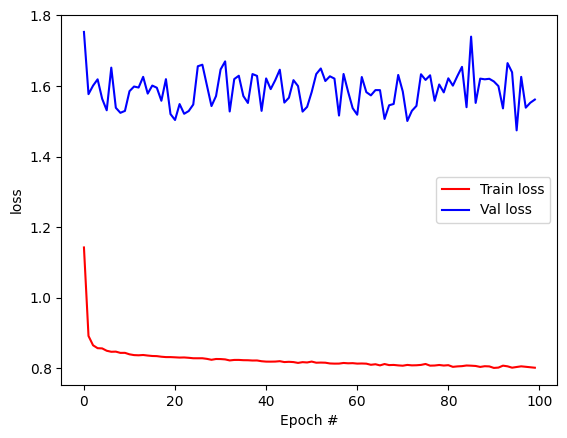

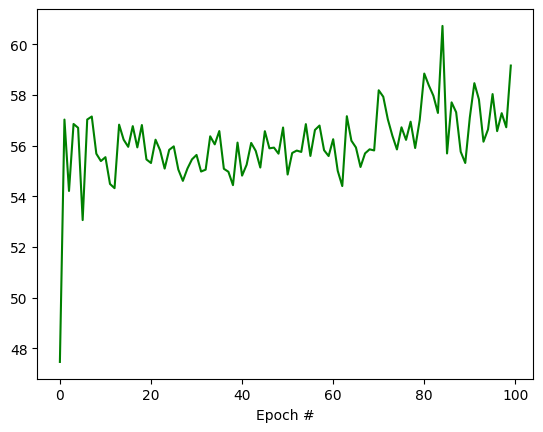

In [88]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(train_errs))], train_errs,color='r', label='Train loss')
plt.plot([i for i in range(len(train_errs))], val_errs,color='b', label='Val loss')
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot([i for i in range(len(accuracies))], accuracies, color='green', label='Accuracy')
plt.xlabel('Epoch #')
plt.show()